# Introduction

This notebook is dedicated to exploring and visualizing data features within the context of a coffee shop sales dataset. The primary objective is to understand the distribution and relationships of various features within the dataset, which will ultimately aid in gaining deeper insights into sales performance and customer behavior.

The dataset under analysis contains various features related to coffee shop sales, including transaction details, product information, customer demographics, and more. The main focus of our analysis is the revenue column, which is derived by multiplying the transaction quantity by the unit price. By leveraging this information, we can uncover patterns and trends that can help optimize sales strategies and improve business operations.

Throughout this notebook, i will perform an extensive exploratory data analysis (EDA) to uncover insights and relationships within the dataset. This involves visualizing the distribution of features, examining correlations between variables, and identifying key indicators of sales performance. Specifically, we will focus on plotting sales data by month and day to understand seasonal trends, peak sales periods, and customer purchasing behavior. By analyzing the coffee shop sales data, we can gain valuable insights into which products are most popular, which time periods see the highest sales, and how different factors such as promotions or holidays impact revenue. This knowledge enables coffee shop owners and managers to make informed decisions, such as adjusting inventory levels, planning marketing campaigns, and optimizing staffing schedules to meet customer demand.



In [27]:
#!nvcc -V && which nvcc

In [28]:
#!python --version
#!nvidia-smi

In [29]:
# !pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com

# Importing Libraries

In [30]:
# importing libraries fundamentals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import warnings
import datetime
from matplotlib import pyplot

import plotly.graph_objects as go
import plotly.express as px
import cufflinks as cf
%matplotlib inline


# Library for Null Values Imputing
import missingno as msno
from sklearn.impute import KNNImputer


from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# importing cudas

# Loading the Dataset

In [31]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/coffee-sales/Coffee Shop Sales.xlsx


In [32]:
# load cudas extension

# %load_ext cudf.pandas

# import data from gdrive

df = pd.read_excel("/kaggle/input/coffee-sales/Coffee Shop Sales.xlsx")

## Dataset Information

In [33]:
df.head(5)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [34]:
df.describe()

,transaction_id,transaction_date,transaction_qty,store_id,product_id,unit_price
count,149116.000000,149116,149116.000000,149116.000000,149116.000000,149116.000000
mean,74737.371872,2023-04-15 11:50:32.173609984,1.438276,5.342063,47.918607,3.382219
min,1.000000,2023-01-01 00:00:00,1.000000,3.000000,1.000000,0.800000
25%,37335.750000,2023-03-06 00:00:00,1.000000,3.000000,33.000000,2.500000
50%,74727.500000,2023-04-24 00:00:00,1.000000,5.000000,47.000000,3.000000
75%,112094.250000,2023-05-30 00:00:00,2.000000,8.000000,60.000000,3.750000
max,149456.000000,2023-06-30 00:00:00,8.000000,8.000000,87.000000,45.000000
std,43153.600016,NaN,0.542509,2.074241,17.930020,2.658723


In [35]:
df.describe(include='object').T

,count,unique,top,freq
transaction_time,149116,25762,09:31:15,41
store_location,149116,3,Hell's Kitchen,50735
product_category,149116,9,Coffee,58416
product_type,149116,29,Brewed Chai tea,17183
product_detail,149116,80,Chocolate Croissant,3076


In [36]:
df.info()

# there by are 32 columns in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [37]:
df.shape
# Dataset has 119390 rows and 32 columns

(149116, 11)

In [38]:
df.dtypes

transaction_id               int64
transaction_date    datetime64[ns]
transaction_time            object
transaction_qty              int64
store_id                     int64
store_location              object
product_id                   int64
unit_price                 float64
product_category            object
product_type                object
product_detail              object
dtype: object

## Find the Categorical dtype and Numerical dtype

In [39]:
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['transaction_time', 'store_location', 'product_category',
       'product_type', 'product_detail'],
      dtype='object')


In [40]:
for col in object_columns:
    d_type = df[col].dtype

counts =df[col].value_counts()
print(f"Counts for {col}:")
print(counts)
print("============================================================")

Counts for product_detail:
product_detail
Chocolate Croissant             3076
Earl Grey Rg                    3053
Dark chocolate Lg               3029
Morning Sunrise Chai Rg         3026
Columbian Medium Roast Rg       3013
                                ... 
Jamacian Coffee River            146
Earl Grey                        142
Guatemalan Sustainably Grown     134
Spicy Eye Opener Chai            122
Dark chocolate                   118
Name: count, Length: 80, dtype: int64


In [41]:
num_columns = df.select_dtypes(include=['float', 'int64']).columns
print(num_columns)

Index(['transaction_id', 'transaction_qty', 'store_id', 'product_id',
       'unit_price'],
      dtype='object')


## Dealt with Null Values



In [42]:
df.isnull().sum()

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

In [43]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Empty DataFrame


# Feature Engineering

In [44]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
sales_per_month = df.groupby(df['transaction_date'].dt.to_period("M"))['transaction_qty'].sum()
print(sales_per_month)

transaction_date
2023-01    24870
2023-02    23550
2023-03    30406
2023-04    36469
2023-05    48233
2023-06    50942
Freq: M, Name: transaction_qty, dtype: int64


In [45]:
# datetime featuring

df["year"] = df["transaction_date"].dt.year
df["month"] = df["transaction_date"].dt.month_name()
df["day"] = df["transaction_date"].dt.day_name()
df["week"] = df["transaction_date"].dt.strftime('%U')
week_names = {str(i): f"Week {i}" for i in range(1, 54)}
df["week"] = df["week"].map(week_names)

# revenue featuring

df['revenue'] = df['transaction_qty'] * df['unit_price']

# Exploratory Data Analysis

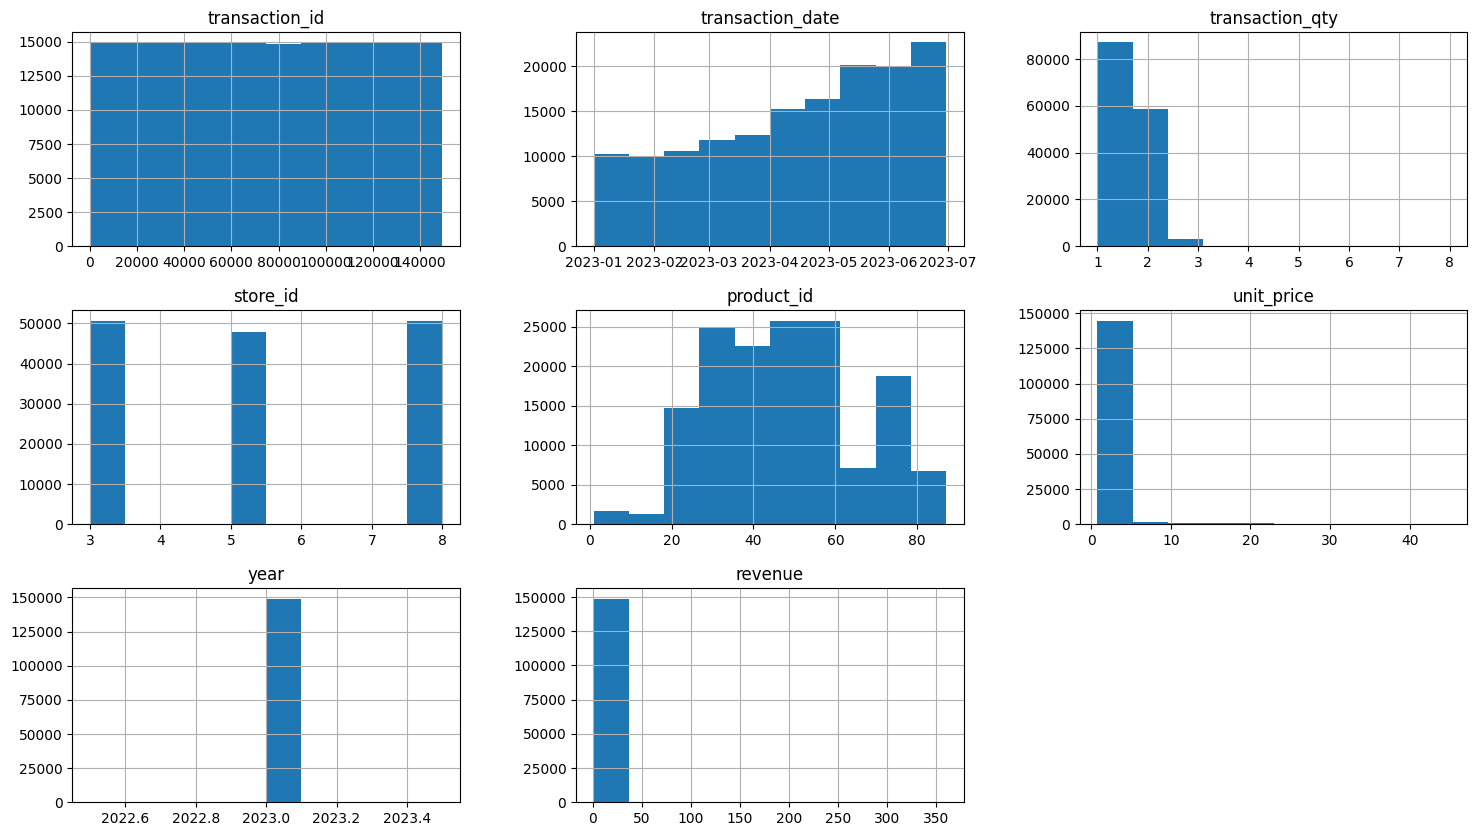

In [46]:
df.hist(figsize=(18, 10))
plt.show()

In [47]:
def plot_pie_single(column):
    target_column = df[column].value_counts()
    plt.figure(figsize=(18, 14))
    fig1, ax1 = plt.subplots()
    ax1.pie(target_column, labels=target_column.index, autopct='%1.1f%%', shadow=None)
    ax1.axis('equal')
    plt.title(f"{column}_Value_Counts", fontsize=14)
    plt.show()

In [48]:
def plot_bar_single(column):
    target_column = df[column].value_counts()
    plt.figure(figsize=(12, 8))
    target_column.plot(kind='bar', color=plt.cm.tab20(range(len(target_column))))
    plt.title(f"{column}_Value_Counts", fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

## Plotting Target Column (revenue)

In [49]:
df['revenue'].unique()

array([  6.  ,   6.2 ,   9.  ,   2.  ,   3.  ,   4.  ,   4.25,   7.  ,
         2.55,   3.1 ,   3.75,   2.5 ,   4.75,   5.1 ,   3.25,   3.5 ,
         7.5 ,   5.  ,   4.5 ,   4.4 ,   2.45,   8.5 ,   9.5 ,   2.2 ,
         8.  ,   4.9 ,   1.6 ,   8.95,   0.8 ,  21.  ,  28.  ,   6.4 ,
        19.75,  12.  ,  18.  ,  10.  ,  20.45,   2.4 ,   9.25,  22.5 ,
        36.  ,  14.75,   7.6 ,  14.  ,   3.2 ,   6.5 ,  10.95,  13.33,
        15.  ,   4.38,   4.06,   5.63,   4.69,  45.  ,  23.  ,  10.5 ,
         9.3 ,   2.1 , 360.  ,  12.75,   4.2 ,  11.25,   6.6 ,   2.65,
         5.3 ,   7.35,  13.5 ,   7.65,   6.3 ,   7.95,  14.25,  56.  ,
        72.  ,  24.  ,  17.  ])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



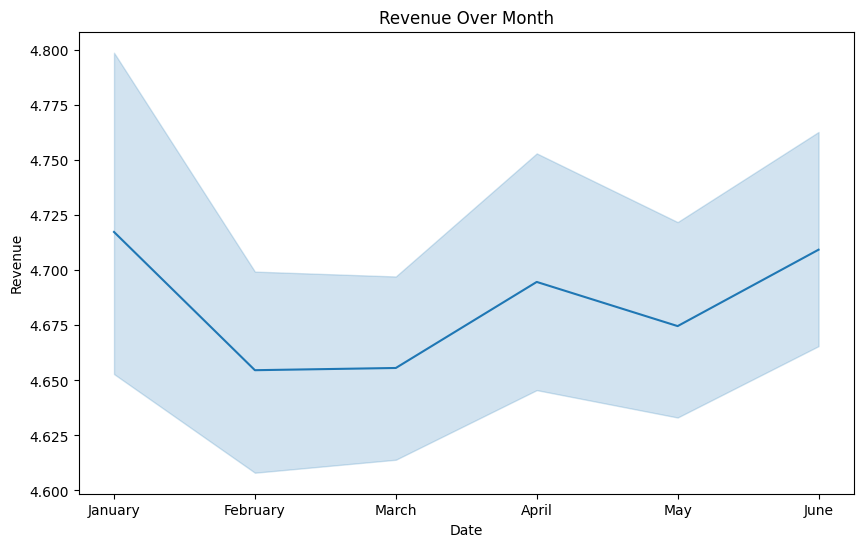

In [50]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['month'], y=df['revenue'])
plt.title('Revenue Over Month')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

## Plotting All Data Features

<Figure size 1800x1400 with 0 Axes>

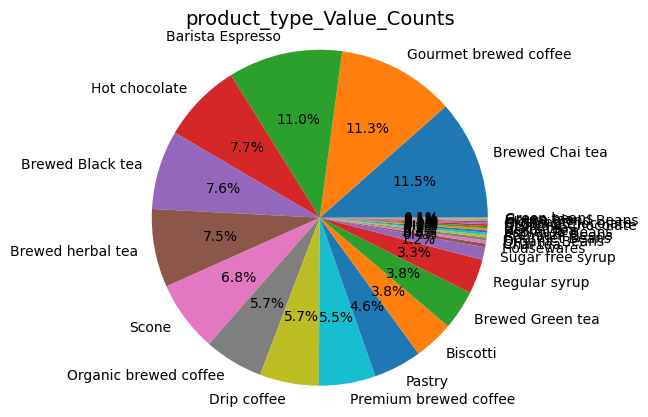

In [51]:
plot_pie_single("product_type")

<Figure size 1800x1400 with 0 Axes>

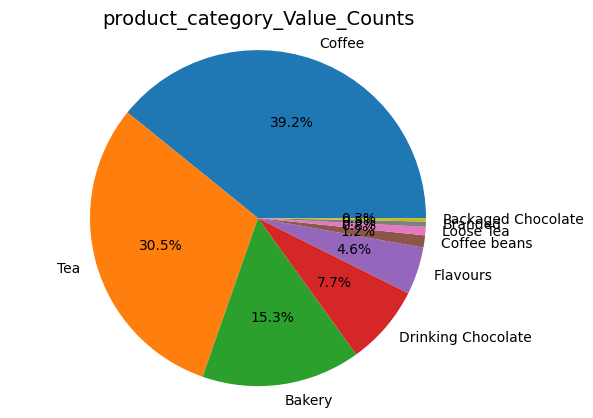

In [52]:
plot_pie_single("product_category")

In [53]:
df["product_category"].unique()

array(['Coffee', 'Tea', 'Drinking Chocolate', 'Bakery', 'Flavours',
       'Loose Tea', 'Coffee beans', 'Packaged Chocolate', 'Branded'],
      dtype=object)

month      AprilFebruaryJanuaryJuneMarchMay
revenue                           698812.33
dtype: object


(60000.0, 180000.0)

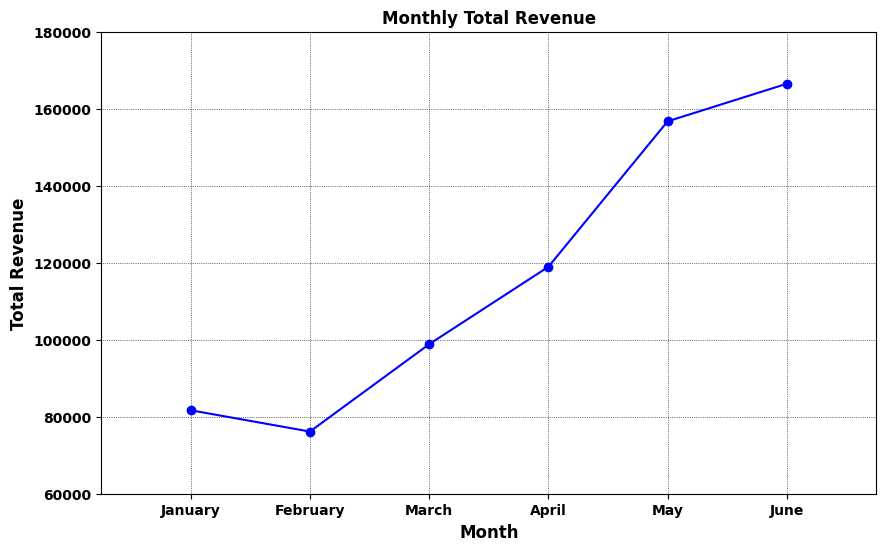

In [54]:
#Figure 1
# Group data by month and calculate total revenue for each month
monthly_revenue = df.groupby("month")["revenue"].sum().reset_index()
print(monthly_revenue.sum())

# Define the order of months starting from January
months_order = df['month'].unique()

# Sort the DataFrame by the "month" column with the defined order
monthly_revenue["month"] = pd.Categorical(monthly_revenue["month"], categories=months_order, ordered=True)
monthly_revenue = monthly_revenue.sort_values("month")

# Plot monthly total revenue
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(monthly_revenue["month"], monthly_revenue["revenue"], marker='o', color='blue', linestyle='-')
plt.title('Monthly Total Revenue', fontsize=12, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Total Revenue', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=10, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(True, linestyle='dotted', linewidth=0.5, color='black')  # Add grid lines


# Add grid lines
plt.grid(True, which='major', axis='both', color='black', linestyle='dotted')

# Ensure x-axis ends in a major tick
plt.xlim(left=plt.xlim()[0] - 0.5, right=plt.xlim()[1] + 0.5)

# Ensure y-axis ends in a major tick
plt.ylim(bottom=60000, top=180000)

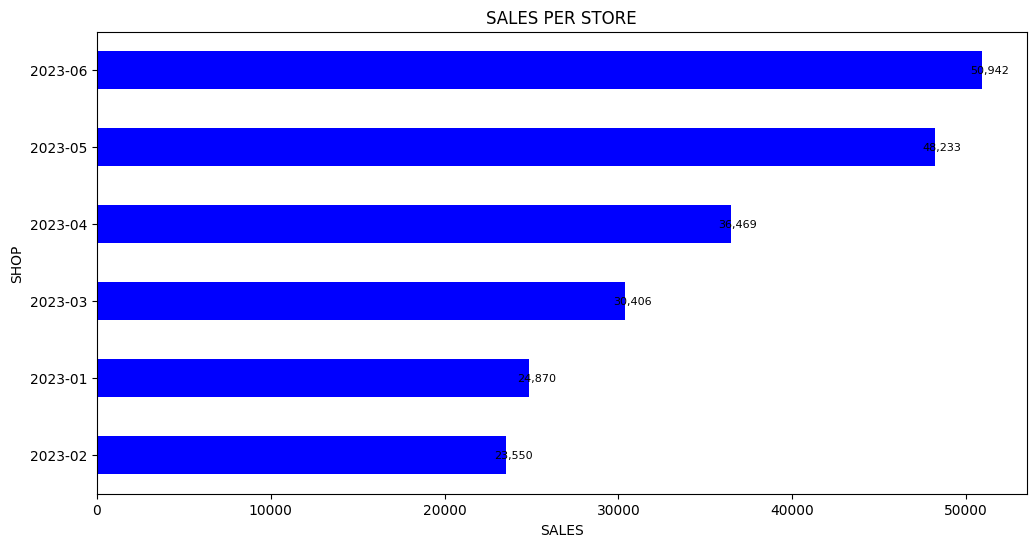

In [55]:
sales_per_month = sales_per_month.sort_values(ascending=True)

plt.figure(figsize=(12, 6))
bars = sales_per_month.plot(kind='barh', color='blue')

plt.xlabel('SALES')
plt.ylabel('SHOP')
plt.title('SALES PER STORE')

for bar in bars.patches:
  plt.annotate(f'{bar.get_width():,.0f}',
   (bar.get_width(), bar.get_y() + bar.get_height() / 2),
   ha='center', va='center',
   xytext=(5, 0),
   textcoords='offset points',
   fontsize=8,
   color='black')

plt.show()

month             AprilAprilAprilFebruaryFebruaryFebruaryJanuary...
store_location    AstoriaHell's KitchenLower ManhattanAstoriaHel...
revenue                                                   698812.33
dtype: object


(20000.0, 60000.0)

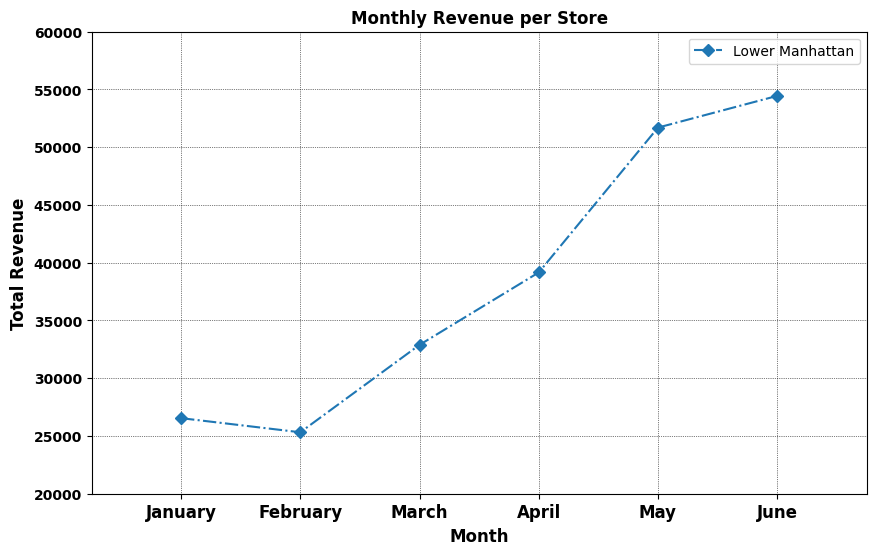

In [57]:
#figure 2

# Group data by month and store_location and calculate total revenue for each combination
monthly_revenue_per_store = df.groupby(["month", "store_location"])["revenue"].sum().reset_index()
print(monthly_revenue_per_store.sum())
# Define the order of months starting from January
months_order = df['month'].unique()

# Sort the DataFrame by the "month" column with the defined order
monthly_revenue_per_store["month"] = pd.Categorical(monthly_revenue_per_store["month"], categories=months_order,
ordered=True)
monthly_revenue_per_store = monthly_revenue_per_store.sort_values(["month", "store_location"])

# Plot monthly total revenue for each store
plt.figure(figsize=(10, 6), facecolor='white')

# Define line styles and markers for each store
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', 'x']

# Iterate over unique store locations and plot monthly revenue
for i, store in enumerate(monthly_revenue_per_store['store_location'].unique()):
    store_data = monthly_revenue_per_store[monthly_revenue_per_store['store_location'] == store]

plt.plot(store_data["month"], store_data["revenue"], marker=markers[i % len(markers)],
         linestyle=line_styles[i % len(line_styles)], label=store)

plt.title('Monthly Revenue per Store', fontsize=12, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Total Revenue', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(True, linestyle='dotted', linewidth=0.5, color='black')  # Add grid lines
plt.legend(fontsize=10)
# Add grid lines
plt.grid(True, which='major', axis='both', color='black', linestyle='dotted')

# Ensure x-axis ends in a major tick
plt.xlim(left=plt.xlim()[0] - 0.5, right=plt.xlim()[1] + 0.5)

# Ensure y-axis ends in a major tick
plt.ylim(bottom=20000, top=60000)

day
Friday       21701
Thursday     21654
Monday       21643
Wednesday    21310
Tuesday      21202
Sunday       21096
Saturday     20510
Name: count, dtype: int64


<Axes: xlabel='day'>

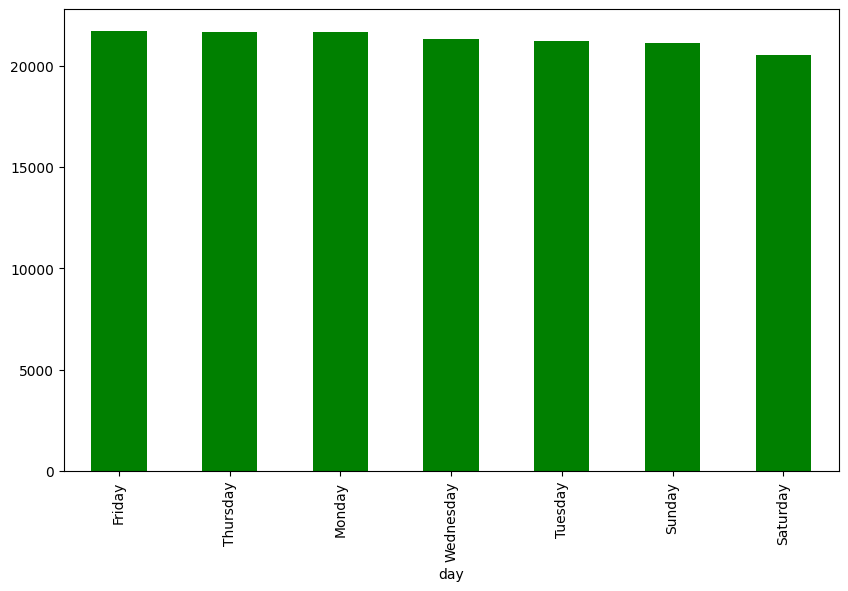

In [58]:
transactions_per_day = df['day'].value_counts()
transactions_per_day = transactions_per_day.sort_values(ascending=False)
print(transactions_per_day)
plt.figure(figsize=(10, 6))
transactions_per_day.head(15).plot(kind='bar', color='green')

         day    revenue
3     Sunday   98330.31
1     Monday  101677.28
5    Tuesday   99455.94
6  Wednesday  100313.54
4   Thursday  100767.78
0     Friday  101373.00
2   Saturday   96894.48


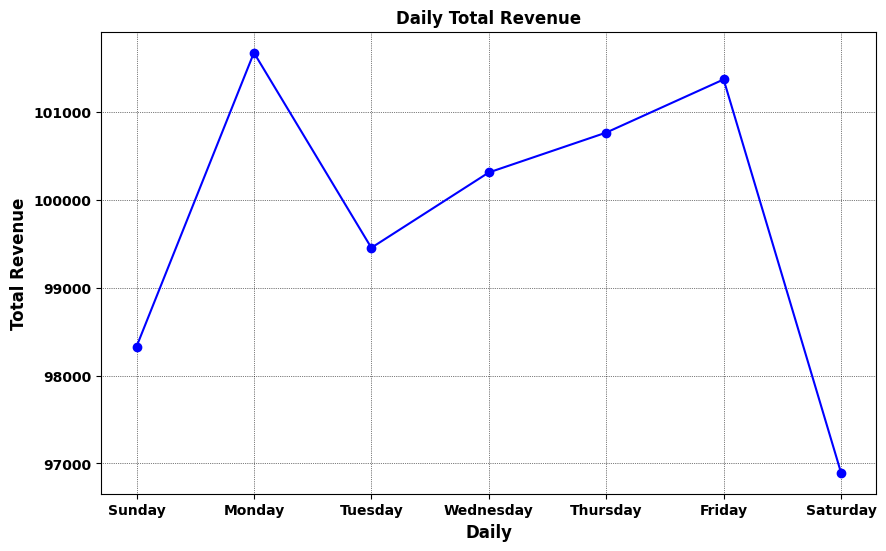

In [59]:
daily_revenue = df.groupby("day")["revenue"].sum().reset_index()
daily_order = df['day'].unique()
daily_revenue['day'] = pd.Categorical(daily_revenue["day"], categories=daily_order, ordered=True)
daily_revenue = daily_revenue.sort_values("day")

print(daily_revenue)

# Plot monthly total revenue
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(daily_revenue["day"], daily_revenue["revenue"], marker='o', color='blue', linestyle='-')

plt.title('Daily Total Revenue', fontsize=12, fontweight='bold')
plt.xlabel('Daily', fontsize=12, fontweight='bold')
plt.ylabel('Total Revenue', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=10, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(True, linestyle='dotted', linewidth=0.5, color='black')  # Add grid lines
plt.show()

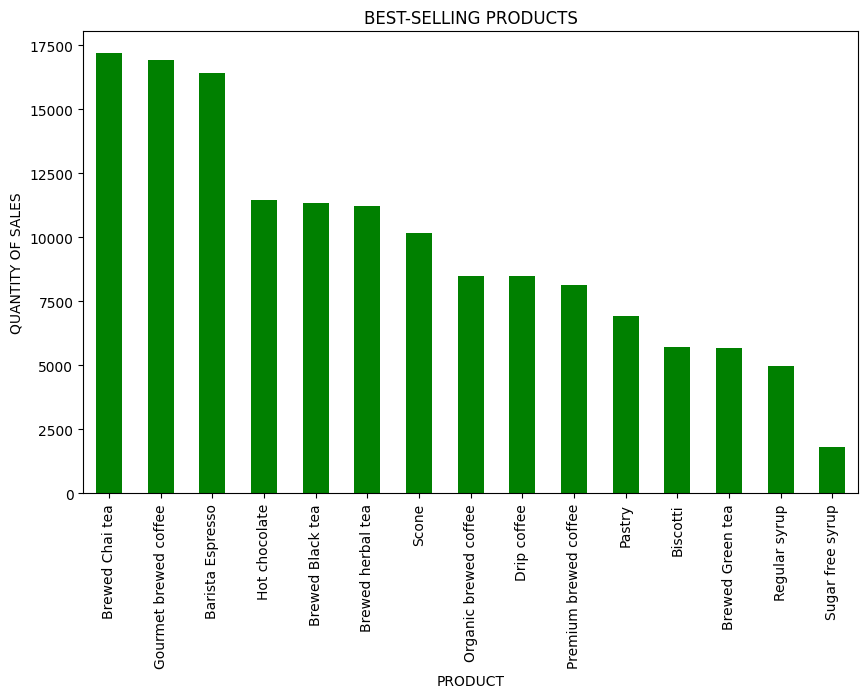

In [60]:
# IDENTIFYING WHICH PRODUCTS ARE SOLD MOST OFTEN!

product_list = df['product_type'].value_counts()
product_list = product_list.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
product_list.head(15).plot(kind='bar', color='green')

plt.xlabel('PRODUCT')
plt.ylabel('QUANTITY OF SALES')
plt.title('BEST-SELLING PRODUCTS')
plt.show()

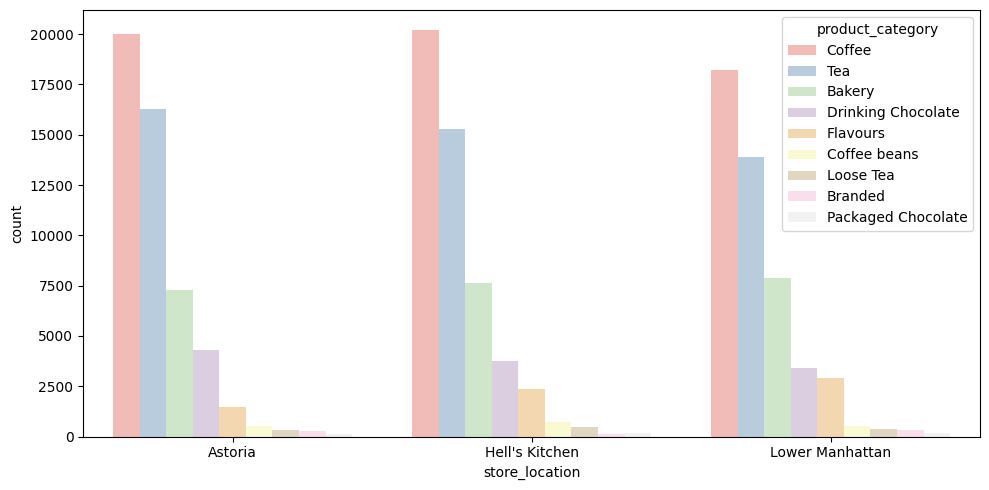

In [61]:
# Stores VS product categories

popular_products = df.groupby('store_location')[['product_category']].value_counts().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.barplot(x = 'store_location', y = 'count', hue = 'product_category', data = popular_products, palette = "Pastel1")
plt.tight_layout()
plt.show()

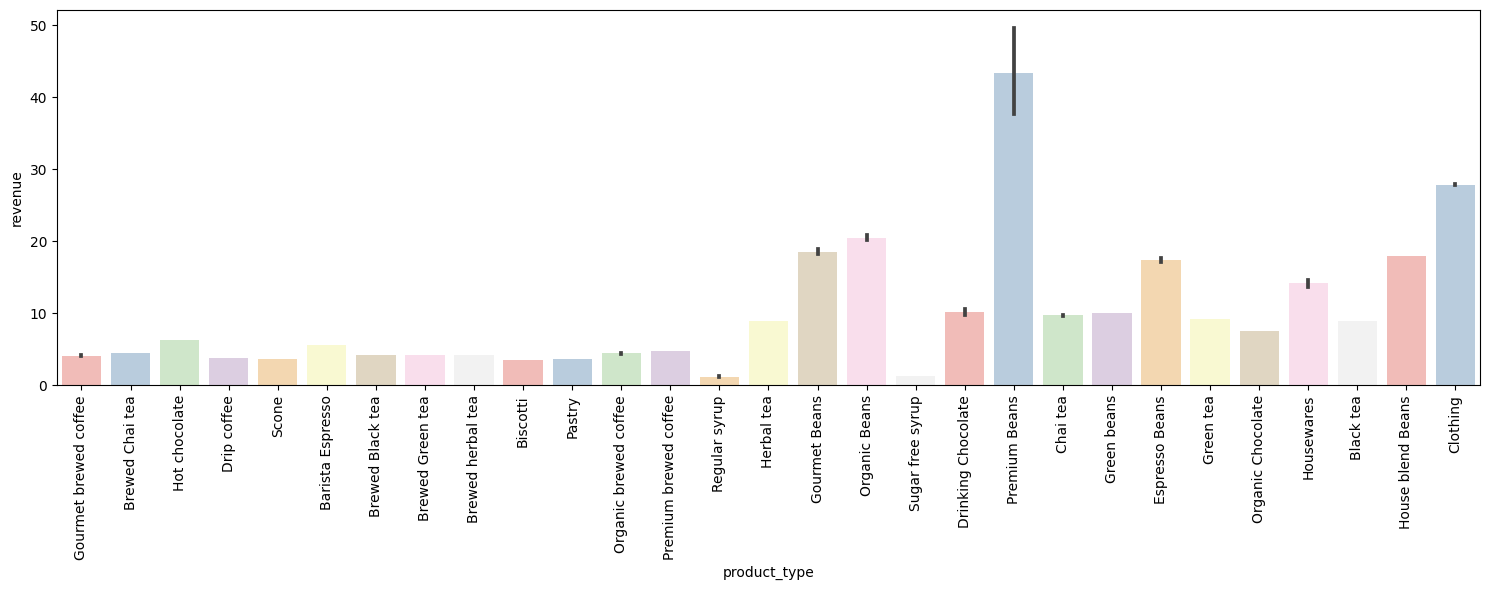

In [62]:
plt.figure(figsize = (15,6))
sns.barplot(x = "product_type", y = "revenue", data = df, palette = "Pastel1")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

698812.33


(1500.0, 4500.0)

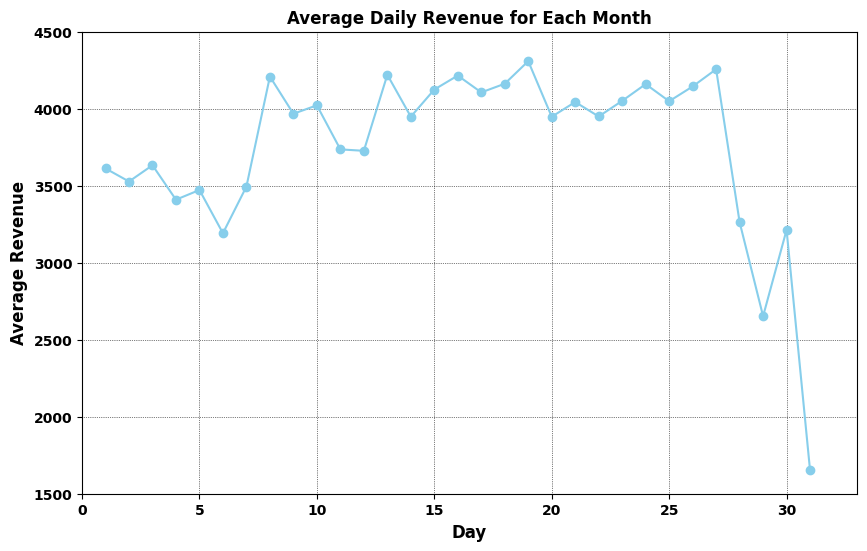

In [63]:
# Combine all daily revenues into one month
combined_revenue = df.groupby(df['transaction_date'].dt.day)['revenue'].sum()
print(combined_revenue .sum())
# Calculate the number of months
num_months = df['transaction_date'].dt.to_period('M').nunique()

# Normalize combined revenues to the number of months to obtain average daily revenues for each month
avg_daily_revenue = combined_revenue / num_months

# Plot average daily revenues for each month
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(avg_daily_revenue.index, avg_daily_revenue.values, marker='o', color='skyblue', linestyle='-')
plt.title('Average Daily Revenue for Each Month', fontsize=12, fontweight='bold')
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Average Revenue', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(True, linestyle='dotted', linewidth=0.5, color='black')  # Add grid lines
# Ensure x-axis ends in a major tick
plt.xlim(left=0, right=plt.xlim()[1] + 0.5)

# Ensure y-axis ends in a major tick
plt.ylim(bottom=1500, top=4500)

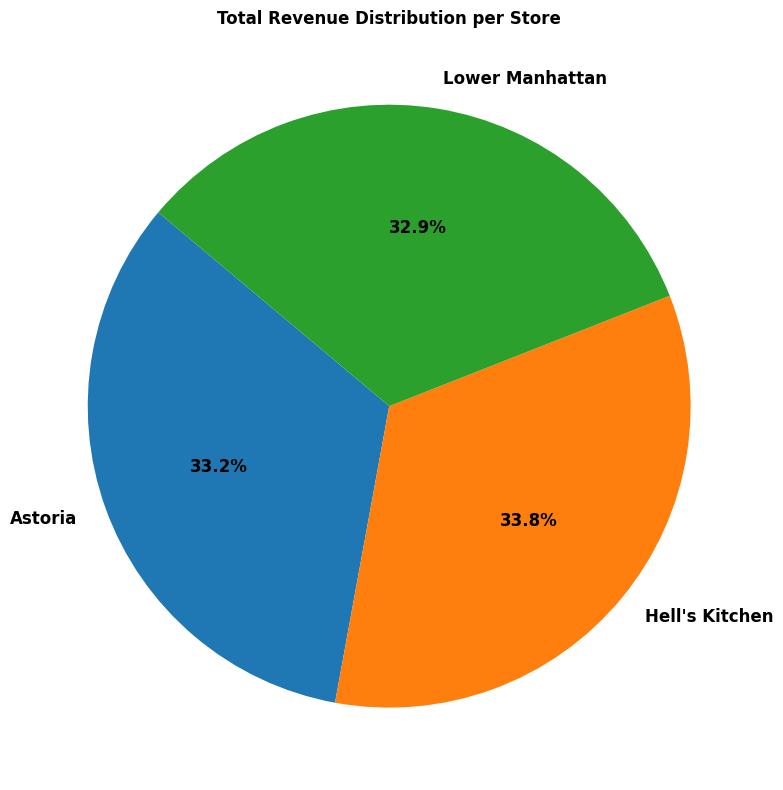

In [64]:
# Figure 9: Pie Plot of Total Revenue per Store
# Group data by store_location and calculate total revenue
total_revenue_per_store = df.groupby('store_location')['revenue'].sum()

# Create a pie plot
plt.figure(figsize=(8, 8))
plt.pie(total_revenue_per_store, labels=total_revenue_per_store.index, autopct='%1.1f%%', 
        startangle=140,textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Total Revenue Distribution per Store', fontsize=12, fontweight='bold')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()

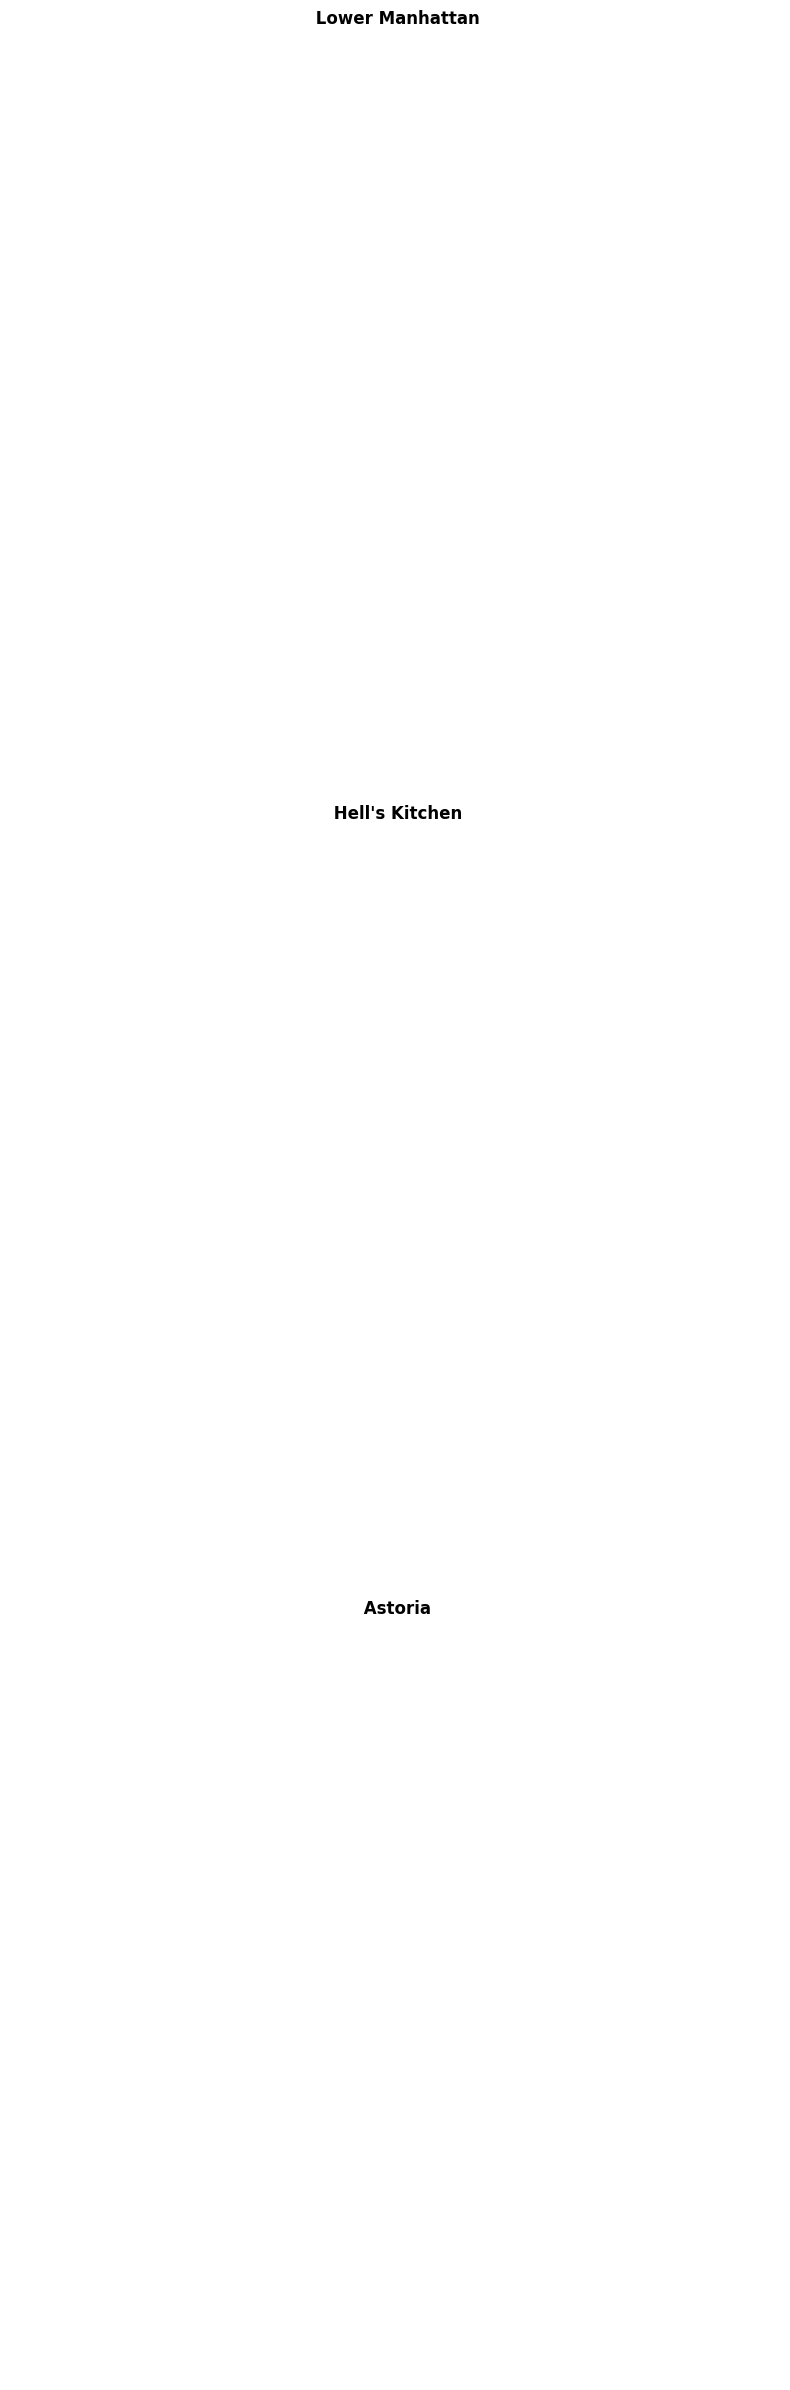

In [68]:
# Group data by store_location and product_category, and calculate total average revenue
total_avg_revenue_per_store_category = df.groupby(['store_location', 'product_category'])['revenue'].mean()

# Create a dictionary to store total average revenue for each store
store_avg_revenue_dict = {store: {} for store in df['store_location'].unique()}

# Populate the dictionary with total average revenue for each store and product category combination
for (store, category), revenue in total_avg_revenue_per_store_category.items():
    store_avg_revenue_dict[store][category] = revenue

# Create subplots for each store
fig, axes = plt.subplots(nrows=len(store_avg_revenue_dict), ncols=1, figsize=(8, 8 * len(store_avg_revenue_dict)))

# If there's only one subplot, axes will not be an array. Make sure it's always an array.
if len(store_avg_revenue_dict) == 1:
    axes = [axes]

# Create a pie chart for each store showing the total average revenue segmented by product category
for i, (store, category_revenues) in enumerate(store_avg_revenue_dict.items()):
    ax = axes[i]
    ax.pie(category_revenues.values(), labels=category_revenues.keys(), autopct='%1.1f%%', startangle=140,
           textprops={'fontsize': 10, 'fontweight': 'bold'})
    ax.set_title(f'{store}', fontsize=12, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()